# TESLA株を予測する

###①ライブラリインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error

#from google.colab import drive
#drive.mount('/content/gdrive')


###②パラメータ設定

In [2]:
# 必要情報の入力
seq_length = 30 #周期性がどの程度あるのか？ここをよく見ながら設定すること！！
num_test = 2 # 予測区間
hidden_size = 300 # 隠れ層数の設定
num_epochs = 200 # エポック数の設定
learningrate=0.001 # 学習率の設定
# ランダムシードの固定化
seed_value = 42
np.random.seed(seed_value)

plt.style.use("ggplot")
%matplotlib inline

###③教師データ準備

In [3]:
# 株価取得の設定パラメータ
start = '2021-01-04'
end = '2024-02-01'
tickers = 'TSLA'  # 予測対象の株価シンボル
# 株価データの取得
ori_y = yf.download(tickers, start=start, end=end)["Close"]
vol_y = yf.download(tickers,start=start,end=end)["Volume"]
# yfinance Parameter : Open Close High Low Volume

# データの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ori_y.values.reshape(-1, 1))
print(scaled_data.size)
vol_scaled_data = scaler.fit_transform(vol_y.values.reshape(-1, 1))

y = scaled_data
v = vol_scaled_data
y = y.squeeze()
v = v.squeeze()

allsize = y.shape[0]
x = np.linspace(0,allsize-1,allsize)
print(y.shape)
print(v.shape)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

774
(774,)
(774,)


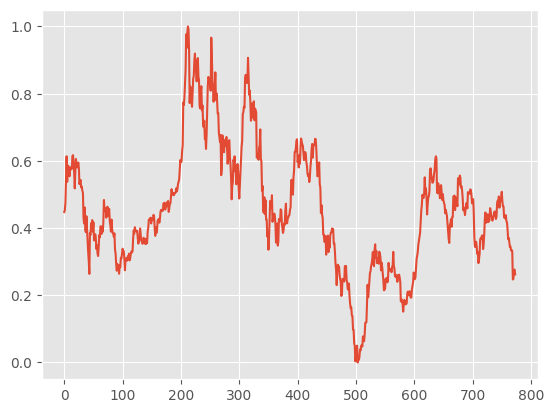

In [4]:
plt.plot(x,y)

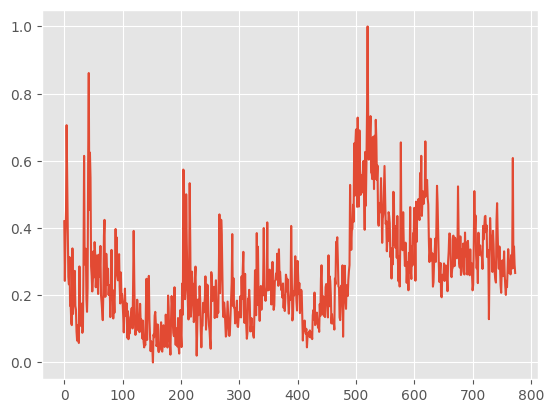

In [5]:
plt.plot(x,v)

###④Window sizeの設定

In [6]:
def make_sequence_data(y, v, num_sequence):
  num_data = len(y)
  seq_data = [] # 刻みのデータを格納する用のリスト
  seq_data2 = [] # 刻みのデータを格納する用のリスト

  target_data = [] # seq_dataの1つ次のデータを格納する用のリスト
  target_data2 = [] # seq_dataの1つ次のデータを格納する用のリスト
  for i in range(num_data - num_sequence):
    seq_data.append(y[i : i + num_sequence])
    seq_data2.append(v[i : i + num_sequence])
    target_data.append(y[i+num_sequence : i + num_sequence + 1])
    target_data2.append(v[i+num_sequence : i + num_sequence + 1])
  seq_arr = np.array(seq_data)
  seq_arr2 = np.array(seq_data2)
  target_arr = np.array(target_data)
  target_arr2 = np.array(target_data2)
  #return seq_arr, target_arr
  return seq_arr.squeeze(),seq_arr2.squeeze(), target_arr.squeeze(), target_arr2.squeeze()

In [7]:
y_seq, v_seq, y_target,v_target = make_sequence_data(y , v, seq_length)
y_seq_train = y_seq[:-num_test]
v_seq_train = v_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
v_seq_test = v_seq[-num_test:]

y_target_train = y_target[:-num_test]
v_target_train = v_target[:-num_test]
y_target_test = y_target[-num_test:]
v_target_test = v_target[-num_test:]


In [8]:
print(y_seq_train.shape)
print(v_seq_train.shape)

(742, 30)
(742, 30)


###⑤pyTorch用にデータ変換

In [9]:
# tensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
v_seq_t = torch.FloatTensor(v_seq_train)

y_target_t = torch.FloatTensor(y_target_train)
v_target_t = torch.FloatTensor(v_target_train)

print(f"y_set_t:{y_seq_t.shape} v_set_t:{v_seq_t.shape} y_target_t:{y_target_t.shape}")

y_set_t:torch.Size([742, 30]) v_set_t:torch.Size([742, 30]) y_target_t:torch.Size([742])


###⑥LSTM定義

In [10]:
class LSTM(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size = 1,hidden_size = self.hidden_size)
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x, _ =self.lstm(x)
    x_last = x[-1] #予測の末尾を取得
    x = self.linear(x_last)
    return x

In [11]:
"""
class DualInputLSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.lstm2 = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size * 2, 1)

    def forward(self, x1, x2):
        # LSTM1とLSTM2にそれぞれの波形データを渡す
        _, (hidden1, _) = self.lstm1(x1)
        _, (hidden2, _) = self.lstm2(x2)

        # LSTMの隠れ状態を結合する
        combined_hidden = torch.cat((hidden1[-1], hidden2[-1]), dim=1)

        # 結合された隠れ状態を線形層に渡して予測を行う
        output = self.linear(combined_hidden)
        return output
"""

'\nclass DualInputLSTM(nn.Module):\n    def __init__(self, hidden_size):\n        super().__init__()\n        self.hidden_size = hidden_size\n        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hidden_size)\n        self.lstm2 = nn.LSTM(input_size=1, hidden_size=self.hidden_size)\n        self.linear = nn.Linear(self.hidden_size * 2, 1)\n\n    def forward(self, x1, x2):\n        # LSTM1とLSTM2にそれぞれの波形データを渡す\n        _, (hidden1, _) = self.lstm1(x1)\n        _, (hidden2, _) = self.lstm2(x2)\n\n        # LSTMの隠れ状態を結合する\n        combined_hidden = torch.cat((hidden1[-1], hidden2[-1]), dim=1)\n\n        # 結合された隠れ状態を線形層に渡して予測を行う\n        output = self.linear(combined_hidden)\n        return output\n'

In [12]:
class DualInputLSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.lstm2 = nn.LSTM(input_size=1, hidden_size=self.hidden_size)
        self.linear = nn.Linear(self.hidden_size * 2, 1)

    def forward(self, x1, x2):
        # LSTM1とLSTM2にそれぞれの波形データを渡す
        _, (hidden1, _) = self.lstm1(x1)
        _, (hidden2, _) = self.lstm2(x2)

        # LSTMの隠れ状態を結合する
        combined_hidden = torch.cat((hidden1[-1], hidden2[-1]), dim=1)

        # 結合された隠れ状態を線形層に渡して予測を行う
        output = self.linear(combined_hidden)

        # サイズを調整して出力
        return output.unsqueeze(1)  # サイズを (バッチサイズ, 1) に変更して出力


In [13]:
class ImproveDualInputLSTM(nn.Module):
  def __init__(self,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size=2,hidden_size=self.hidden_size,num_layers=2)
    self.linear = nn.Linear(self.hidden_size,1)
  def forward(self,x1,x2):
    x2_scaled = x2 * 1.0
    combined_input = torch.cat((x1,x2_scaled),dim=2)
    output, _ = self.lstm(combined_input)
    output = self.linear(output[:, -1, :])
    return output.unsqueeze(1)

In [14]:
#model = DualInputLSTM(hidden_size)
model = ImproveDualInputLSTM(hidden_size)
#model = LSTM(hidden_size)


In [15]:
# Loss関数と最適化アルゴリズムの設定
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learningrate)

###⑦LSTMに入力するための処理

In [16]:
y_seq_t = y_seq_t.permute(1,0)
v_seq_t = v_seq_t.permute(1,0)
# LSTMにインプットする際に先にシーケンス上の軸が来て、つぎにバッチサイズが来る、
#最後にインプットサイズの軸が来る
# y_seq_tの順番が逆であるので入れ替える必要がある

In [17]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
v_seq_t = v_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)
v_target_t = v_target_t.unsqueeze(dim=-1)
# 50×699の2次元テンサーなので、1次元にする必要がる
# unsqueezeはsqueezeの反対なのでsqueezeは50x699x1を絞って50x4699にするがunsqueezeは次元を広げる働きがある。dim=-1にすると最後の列に1を付与できる

In [18]:
y_seq_t.shape

torch.Size([30, 742, 1])

###⑧学習トレーニング


In [19]:
"""
import torch.nn.init as init

# モデルを初期化する関数
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.LSTM)):
        for name, param in m.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)
            elif 'bias' in name:
                init.constant_(param, 0)

# モデルを定義する
model = LSTM(hidden_size)

# モデルに初期化関数を適用する
model.apply(init_weights)
"""

"\nimport torch.nn.init as init\n\n# モデルを初期化する関数\ndef init_weights(m):\n    if isinstance(m, (nn.Linear, nn.LSTM)):\n        for name, param in m.named_parameters():\n            if 'weight' in name:\n                init.xavier_uniform_(param)\n            elif 'bias' in name:\n                init.constant_(param, 0)\n\n# モデルを定義する\nmodel = LSTM(hidden_size)\n\n# モデルに初期化関数を適用する\nmodel.apply(init_weights)\n"

In [20]:
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(y_seq_t, v_seq_t)
    #output = model(y_seq_t)
    # 予測結果とターゲット値の損失を計算する
    #loss = criterion(output, y_target_t[:output.shape[0]])
    #y_target_t = torch.flatten(y_target_t)
    #output = output[:y_target_t.shape[0]]  # y_target_tと同じ長さに切り取る
    loss = criterion(output, y_target_t)
    #3月9日宿題→outputサイズとy_target_tサイズがそろってないので調整必要
    # print(f"Input tensor shape: {output.shape}")
    # print(f"Target tensor shape: {y_target_t.shape}")

    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([742, 1])) that is different to the input size (torch.Size([30, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.17787465453147888
epoch: 10, loss: 0.04827331751585007
epoch: 20, loss: 0.04034341499209404
epoch: 30, loss: 0.037665534764528275
epoch: 40, loss: 0.03661384806036949
epoch: 50, loss: 0.03609781339764595
epoch: 60, loss: 0.03578735142946243
epoch: 70, loss: 0.03557882830500603
epoch: 80, loss: 0.03541465103626251
epoch: 90, loss: 0.03526927903294563
epoch: 100, loss: 0.03513520210981369
epoch: 110, loss: 0.03501226007938385
epoch: 120, loss: 0.034899305552244186
epoch: 130, loss: 0.03479509800672531
epoch: 140, loss: 0.034699343144893646
epoch: 150, loss: 0.034611813724040985
epoch: 160, loss: 0.03453229367733002
epoch: 170, loss: 0.03446068614721298
epoch: 180, loss: 0.034397006034851074
epoch: 190, loss: 0.03434135392308235


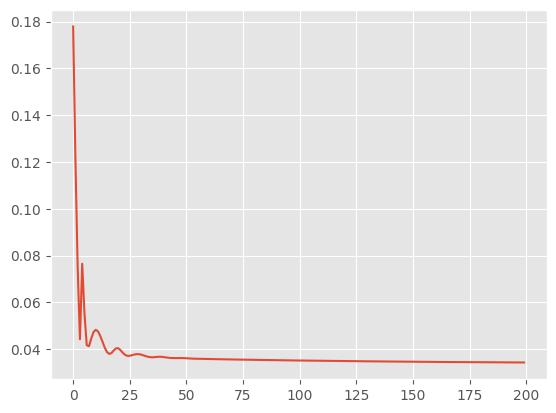

In [21]:
# Loss関数の推移を確認
plt.plot(losses)

###⑨テストデータでの予測精度確認

In [22]:
y_seq_test_t = torch.FloatTensor(y_seq_test)
y_seq_test_t = y_seq_test_t.permute(1,0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)
y_seq_test_t.size()

v_seq_test_t = torch.FloatTensor(v_seq_test)
v_seq_test_t = v_seq_test_t.permute(1,0)
v_seq_test_t = v_seq_test_t.unsqueeze(dim=-1)
v_seq_test_t.size()


y_pred = model(y_seq_test_t,v_seq_test_t)
#y_pred = model(y_seq_test_t)

In [23]:
y_pred.size()

torch.Size([30, 1, 1])

(754.0, 776.0)

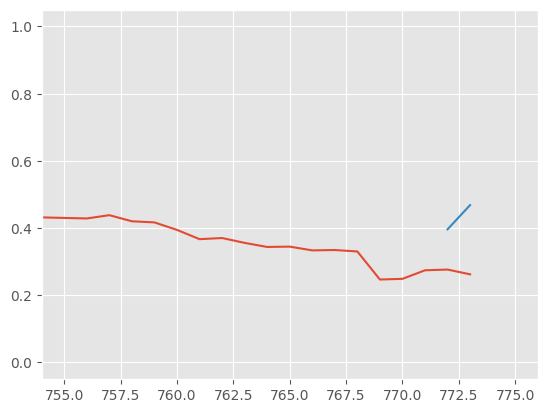

In [24]:
plt.plot(x,y)
plt.plot(np.arange(allsize - num_test, allsize), y_pred.detach()[:num_test].squeeze().numpy())

#plt.plot(np.arange(allsize-num_test,allsize),y_pred.detach()[:num_test])
plt.xlim([allsize-num_test*10,allsize+num_test])

#plt.plot(x, y)
#plt.plot(np.arange(allsize - num_test, allsize), y_pred.detach()[:num_test].numpy())
#plt.xlim([allsize - num_test * 10, allsize + num_test])


RMSE: 0.16850856262850966


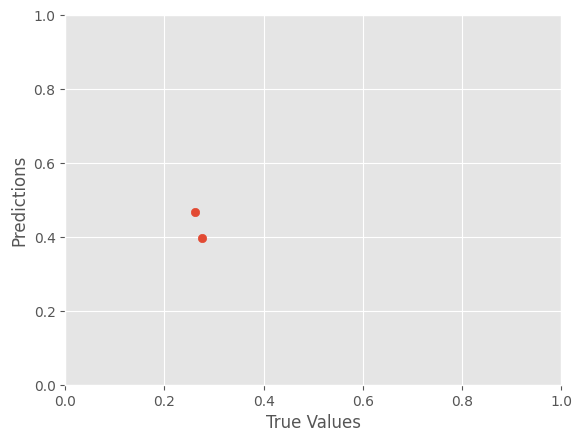

In [25]:
# y_true と y_pred を用意
y_true = y[allsize-num_test:allsize]
y_pred = y_pred.detach()[:num_test].squeeze().numpy()

# RMSE を計算する
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# 縦軸と横軸の範囲を同じにする
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()


### ⓾未知データ予測

In [26]:
scaled_data = scaler.fit_transform(ori_y.values.reshape(-1, 1))

# prediction loop
pred_days=30
#maxnum=len(scaled_data)
ii=0
jj=0
kk=0
#yy=[]
for kk in range(pred_days):
  yy=[]
  for ii in range(seq_length):
    for jj in range(num_test):
      yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])
      yy.append(yy_value)
      jj+=1
  #if(ii==seq_length-1):
    #print(f"count:{ii+jj-seq_length-num_test+2} {yy}")
  #print(yy)
  # yyをtorch.Tensorに変換
  yy_tensor = torch.tensor(yy)
  yy_tensor_reshaped = yy_tensor.view(seq_length,num_test)
  yy_tensor_reshaped = yy_tensor_reshaped.unsqueeze(dim=-1)
  #print(yy_tensor_reshaped)
  #print(yy_tensor_reshaped.size())
  # prediction
  y_pred2 = model(yy_tensor_reshaped)
  print(f"prediction:{y_pred2[-1]}")
  # y_pred2[-1]をscaled_dataの末尾に付与
  scaled_data_tensor = torch.tensor(scaled_data)
  scaled_data = torch.cat((scaled_data_tensor, y_pred2[-1].unsqueeze(0)), dim=0)
#print(scaled_data)

print(scaled_data.size())

<ipython-input-26-b5a2bd3625e8>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yy_value = float(scaled_data[ii+jj-seq_length-num_test+1])


TypeError: ImproveDualInputLSTM.forward() missing 1 required positional argument: 'x2'

### ⑪推論結果を保存する

In [28]:
# 推論時の結果保存
y_predout=scaled_data.detach().numpy()
y_predout2 = pd.DataFrame(y_predout)
#y_predout2.to_csv("/content/gdrive/MyDrive/output/pred_tesla.csv")

In [ ]:
# pred_daysの日数に対応する部分を抽出
pred_data = y_predout2.iloc[-pred_days:]

# 全体をプロット
plt.plot(y_predout2, label='All Data')

# pred_daysの日数に対応する部分を別の色でプロット
plt.plot(pred_data, label='Predicted', color='blue')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted Values')
plt.legend()
plt.show()